In [4]:
import re
import string
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import tensorflow as tf

In [127]:
axistitlesize = 28
axisticksize = 16
axislabelsize = 24
axislegendsize = 20

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

## Exercise 1

Read in a bunch of tweets that were collected during the airing of the 'Red Wedding' episode of Game of Thrones from the file `got_tweets.csv`.

Parse all the hashtags out of the texts, then count their overall occurrences. What are the 10 most common hashtags? Make a bar chart of these top 10 hashtags! Create a plot of hashtag timelines for the most interesting and frequent hashtags!

In [5]:
df = pd.read_csv('./data/got_tweets.csv')

In [6]:
text = df['text']

### Collect hashtags from file

In [115]:
hashtags = []
for tw in text:
    # Convert all hashtags to lowercase
    hashtags.append([i[1:].lower() for i in tw.split() if i.startswith("#")])
hashtags = [w for sublist in hashtags for w in sublist]

### Remove punctuations

In [120]:
hashtags = ['#' + ''.join(c for c in h if c not in string.punctuation) for h in hashtags]

### Count the frequency of different hashtags

In [121]:
hashtag_count = {}
for w in hashtags:
    if w in hashtag_count.keys():
        hashtag_count[w] += 1
    else:
        hashtag_count[w] = 1

In [122]:
hashtag_counts_df = pd.DataFrame({'words': list(hashtag_count.keys()),
                                  'counts': list(hashtag_count.values())}).sort_values(by=['counts'],
                                                                                       ascending=False,
                                                                                       ignore_index=True)

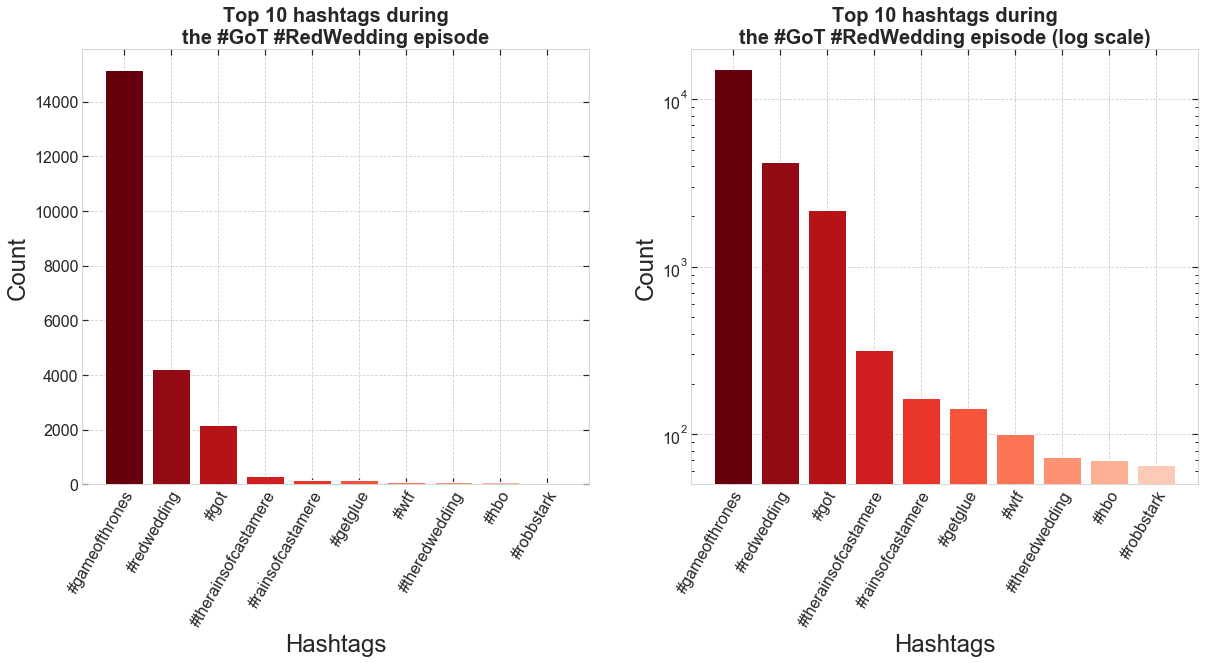

In [128]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*10, nrows*8))

# Number of hashtags plotted
n_hash = 10

# Choose colors for bars
start = 0.0
stop = 0.8
cm_subsection = np.linspace(start, stop, n_hash) 
colors = [cm.Reds_r(i) for i in cm_subsection]

axes[0].set_title('Top {0} hashtags during\nthe #GoT #RedWedding episode'.format(n_hash),
                  fontsize=titlesize, fontweight='bold')
axes[1].set_title('Top {0} hashtags during\nthe #GoT #RedWedding episode (log scale)'.format(n_hash),
                  fontsize=titlesize, fontweight='bold')


for i in range(ncols):
    ax = axes[i]
    ax.bar(x=hashtag_counts_df['words'][:n_hash],
           height=hashtag_counts_df['counts'][:n_hash],
           tick_label=hashtag_counts_df['words'][:n_hash],
           color=colors
          )
    ax.set_xlabel('Hashtags', fontsize=axislabelsize)
    ax.set_ylabel('Count', fontsize=axislabelsize)

    ax.set_xticklabels(hashtag_counts_df['words'][:n_hash],
                       rotation=60, ha='right', rotation_mode='anchor')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize)

axes[1].set_yscale('log')

plt.show()

## Exercise 2

Tokenize the text of the tweets, and gather the 'real' words for each tweet.

By 'real' words, there should be:
* no punctuations
* hashtags only without `#` mark
* no user mentions
* no URLs
* no emojis
* no numbers

Count word occurrences, make a histogram of the occurrences. What are the top words? Are they what you expected?

What crazy words did you get? Explain possible approaches, with which you could throw out this kind of junk text as well.

### Pre-filtering

Filtering out user mentions, URLs, `#` from hashtags and emojis

In [130]:
text_flt = text.copy()

In [131]:
# Creating emoji pattern to remove them
# Helped by https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                               "]+", flags=re.UNICODE)

In [132]:
filters_pre = ['@', 'http', 'RT']
for i, tw in enumerate(text_flt):
    for f in filters_pre:
        if f in tw:
            tw_tmp = filter(lambda x:f not in x, tw.split())
            tw = " ".join(filter(lambda x:f not in x, tw.split()))

    if '#' in tw:
        tw = tw.replace('#', '')

    # Removing emojis
    # Helped by https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    text_flt[i] = emoji_pattern.sub(r'', tw)

### Second filtering

Remove punctuation and numbers

In [133]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [134]:
filters = string.digits + string.punctuation

In [135]:
# Choose the top N words from the vocabulary
top_k = None
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters=filters)

In [136]:
tokenizer.fit_on_texts(text_flt)

In [137]:
# Create the tokenized vectors
text_seqs = tokenizer.texts_to_sequences(text_flt)

### Process filtered data

In [138]:
# Calculate the legngth of the longest vector
max_length = calc_max_length(text_seqs)

In [139]:
word_index = tokenizer.word_index
word_counts = dict(tokenizer.word_counts)

In [140]:
word_counts_df = pd.DataFrame({'words': list(word_counts.keys()),
                               'counts': list(word_counts.values())}).sort_values(by=['counts'],
                                                                                  ascending=False,
                                                                                  ignore_index=True)

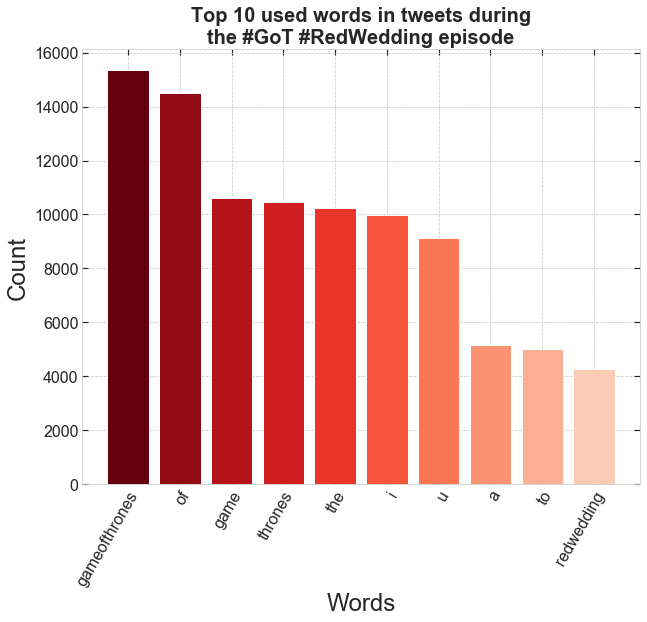

In [146]:
ncols = 1
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*10, nrows*8))

# Number of words plotted
n_words = 10

# Choose colors for bars
start = 0.0
stop = 0.8
cm_subsection = np.linspace(start, stop, n_hash) 
colors = [cm.Reds_r(i) for i in cm_subsection]

axes.bar(x=word_counts_df['words'][:n_words],
         height=word_counts_df['counts'][:n_words],
         tick_label=word_counts_df['words'][:n_words],
         color=colors
        )

axes.set_title('Top {0} used words in tweets during\nthe #GoT #RedWedding episode'.format(n_words),
               fontsize=titlesize, fontweight='bold')

axes.set_xlabel('Words', fontsize=axislabelsize)
axes.set_ylabel('Count', fontsize=axislabelsize)

axes.set_xticklabels(word_counts_df['words'][:n_words],
                     rotation=60, ha='right', rotation_mode='anchor')
axes.tick_params(axis='both', which='major', labelsize=axisticksize)


plt.show()

## Exercise 3


Extract the stopword list for the English language with the help of `nltk`. Download the standard Brown Corpus also from `nltk`, count the relative frequency of stopwords in both the Brown Corpus and the GoT tweets. Make a scatterplot of your results, try to explain possible similarities and deviations. What is the correlation in the stopword frequencies of the two datasets?

## Exercise 4

A really common tool to visualize texts is a wordcloud. Find a suitable library and create a meaningful wordcloud of the GoT tweets (e.g. leave out punctuation, stopwords etc.)

In [109]:
# Using tutorial at here: https://www.datacamp.com/community/tutorials/wordcloud-python

In [148]:
import wordcloud

In [189]:
stopwords = set(wordcloud.STOPWORDS)

To create the wordcloud, I've used the most frequent words with the small trickery by creating a completely arbitrary corpus by filtering all other words from the tweets.

In [190]:
# Collect the N most common words from the text
n = 2000

text_WordCloud = ''
for tw in text_flt:
    text_WordCloud += ' '.join((w for w in tw.split() if(w in word_counts_df['words'][:n].values)
                                                         and
                                                         w not in stopwords)) + ' '

print ("There are {} words in the combination of all filtered tweets.".format(len(text_WordCloud)))

There are 639983 words in the combination of all filtered tweets.


In [195]:
# Generate a word cloud image
got_WordCloud = wordcloud.WordCloud(width=1800, height=900,
                                    max_words=60, background_color='black').generate_from_text(text_WordCloud)

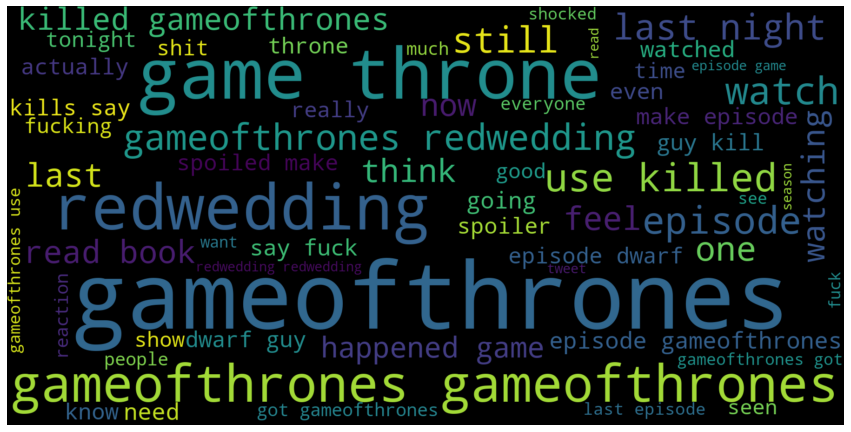

In [196]:
fig, axes = plt.subplots(figsize=(15,15))
axes.set_aspect('equal')
axes.axis('off')

axes.imshow(got_WordCloud, interpolation='bilinear')

plt.show()

## Exercise 5

Define a time window in which all tweets count as one document. Create the term-document matrix of the tweets for this time segmentation. Apply stemming and stopword filtering.

## Exercise 6

Apply a TF-IDF weighting scheme for the term-document matrix by hand (e.g. do not use a built-in vectorizer, but normalize by text length with a summation etc. `numpy` or `pandas` is strongly suggested). Then, choose a topic detection method such as LSI or LDA, and run it on your matrix. Try to interpret your results! Are your topics meaningful? Which topics are the most representative of your document?

## Exercise 7

Write an own name parser for the tweets, and consider all names that you find in the dataset as a node of a graph. Add 1 to the weight of an edge if two names occur in the same tweet. With the help of networkx, draw the weighted network of names from the text. Try to find a simple clustering algorithm in networkx, cluster the names in the dataset. Print or visualize your results!

## Exercise 8

This episode caused severe disappointments in many viewers, because of the sudden death of too many of the favourite characters. Search for some sentiment analysis method, and create a timeline of sentiments based on the tweet texts. Do the sentiments on Twitter reflect the time of the worst scene?